# Group Project Report - Prediction of User Knowledge 


## Introduction


In this project, we aim explore "What is the user's knowledge level on a topic based on their understanding, preparation, and examination results of primary and relevant information?" Using the User Knowledge dataset, we will predict the level of student knowledge (UNS - Very Low, Low, Middle, or High) regarding the topic of electrical DC machines, which are rotational electrical motors that change electrical energy into mechanical energy. We have 5 predictors to choose from: PEG (exam performance based on the topic), LPR (exam performance of prerequisite knowledge), STG (amount of study time), SCG (amount of practice done), and STR (prerequisite knowledge on relevant topics). After refining the variables that possess the greatest weight in determining students' proficiency in the topic, we expect to build a classifier that can quite accurately predict the knowledge level of users based on those predictors. 

Our findings could make an impact by allowing institutions (i.e. schools and businesses) to manipulate data from other disciplines or fields to identify individuals with lower levels of knowledge. This could lead to future questions relating to whether the trajectory or progress of users with lower levels of knowledge can be traced to understand the most optimal procedures to increase their knowledge level.


## Preliminary Exploratory Data Analysis

First, the necessary libraries to analyze our data are read.

In [34]:
library(tidyverse)
library(repr)
library(caret)
library(readxl)
library(curl)
library(httr)

### Reading Data into R

The url containing the data set is downloaded which is then read into R. The data set is already split into one for training and one for testing. 

In [35]:
url <- "http://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls"
download.file(url = url, destfile = "user_data")

In [36]:
training_data_raw <- read_excel("user_data", sheet = 2)
head(training_data_raw)

testing_data_raw <- read_excel("user_data", sheet = 3)
head(testing_data_raw)

New names:
* `` -> ...7
* `` -> ...8



STG,SCG,STR,LPR,PEG,UNS,...7,...8,Attribute Information:
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<lgl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low,NA,NA,"STG (The degree of study time for goal object materails),"
0.08,0.08,0.10,0.24,0.90,High,NA,NA,SCG (The degree of repetition number of user for goal object materails)
0.06,0.06,0.05,0.25,0.33,Low,NA,NA,STR (The degree of study time of user for related objects with goal object)
0.10,0.10,0.15,0.65,0.30,Middle,NA,NA,LPR (The exam performance of user for related objects with goal object)
0.08,0.08,0.08,0.98,0.24,Low,NA,NA,PEG (The exam performance of user for goal objects)
0.09,0.15,0.40,0.10,0.66,Middle,NA,NA,UNS (The knowledge level of user)


New names:
* `` -> ...7
* `` -> ...8



STG,SCG,STR,LPR,PEG,UNS,...7,...8,Attribute Information:
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<lgl>,<chr>
0.00,0.10,0.50,0.26,0.05,Very Low,NA,NA,"STG (The degree of study time for goal object materails),"
0.05,0.05,0.55,0.60,0.14,Low,NA,NA,SCG (The degree of repetition number of user for goal object materails)
0.08,0.18,0.63,0.60,0.85,High,NA,NA,STR (The degree of study time of user for related objects with goal object)
0.20,0.20,0.68,0.67,0.85,High,NA,NA,LPR (The exam performance of user for related objects with goal object)
0.22,0.22,0.90,0.30,0.90,High,NA,NA,PEG (The exam performance of user for goal objects)
0.14,0.14,0.70,0.50,0.30,Low,NA,NA,UNS (The knowledge level of user)


Three extra columns were read that do not contain data from the data set. Thus, they have been selected out. In addition, it seems that the variables do not need to be scaled because each is on the same scale from 0 to 1.

In [37]:
training_data <- select(training_data_raw, STG, SCG, STR, LPR, PEG, UNS)
head(training_data)

testing_data <- select(testing_data_raw, STG, SCG, STR, LPR, PEG, UNS)
head(testing_data)

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.10,0.50,0.26,0.05,Very Low
0.05,0.05,0.55,0.60,0.14,Low
0.08,0.18,0.63,0.60,0.85,High
0.20,0.20,0.68,0.67,0.85,High
0.22,0.22,0.90,0.30,0.90,High
0.14,0.14,0.70,0.50,0.30,Low


We change the classifer to a factor type which is useful for later analysis.

In [38]:
training_data <- training_data %>%
        mutate(UNS = as.factor(UNS))

testing_data <- testing_data %>%
        mutate(UNS = as.factor(UNS))

### Summarizating of Training Data Set

The code below checks to see if there are any missing rows in any of the training data.

In [39]:
anyNA(training_data)

[1] FALSE

None are found! The training data set is complete.

Now, we will find the number of observations in each class in training set.

In [40]:
number_of_rows_training <- training_data %>%
        group_by(UNS) %>%
        summarize(n = n())
number_of_rows_training

UNS,n
<fct>,<int>
High,63
Low,83
Middle,88
very_low,24


The number of observations are similar for three of the four classes. The "very low" class has very few observations which could result in stratification bias. However, oversampling may not be needed for the "very low" class according to the sample scatterplots below. As long as the points that are in the "very low" class are isolated enough on the graph, and if the final k is not too large (i.e. the "very low" class is likely to be the majority class among the k-nearest-neighbors), then upsampling is not neccesary, as the classification algorithm could still accurately predict most "very low" class points. 

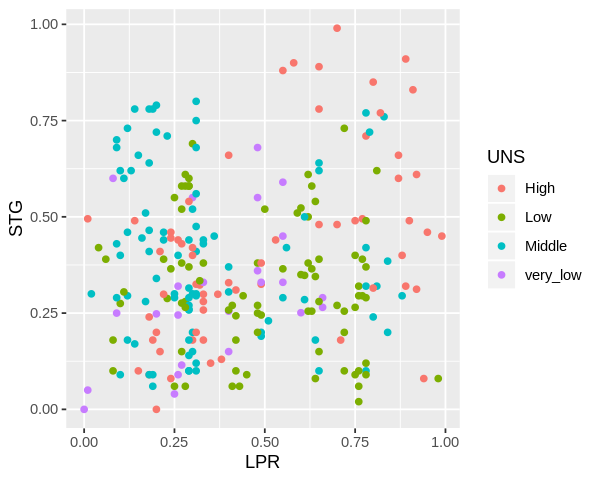

In [41]:
LPR_PEG <- ggplot(training_data, aes(x = LPR, y = STG, color = UNS)) +    
    geom_point() + 
    labs(x = "LPR", y = "STG", color = "UNS")

options(repr.plot.width = 5, repr.plot.height = 4)

LPR_PEG

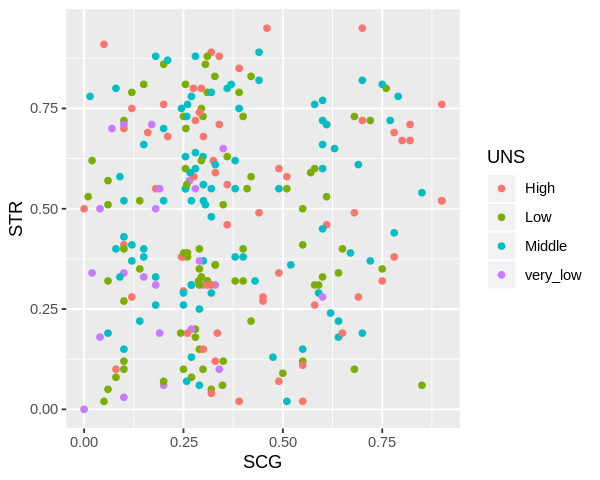

In [42]:
SCG_STR <- ggplot(training_data, aes(x = SCG, y = STR, color = UNS)) +    
    geom_point() + 
    labs(x = "SCG", y = "STR", color = "UNS")

options(repr.plot.width = 5, repr.plot.height = 4)

SCG_STR

The code below finds the mean value of each predictor for each category.

In [43]:
mean_value_training <- training_data %>%
        group_by(UNS) %>%
        summarize(mean_STG = mean(STG), mean_PEG = mean(PEG), mean_LPR = mean(LPR), mean_SCG = mean(SCG), mean_STR = mean(STR))

mean_value_training

UNS,mean_STG,mean_PEG,mean_LPR,mean_SCG,mean_STR
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
High,0.4216508,0.77253968,0.5012698,0.4231905,0.5016667
Low,0.3211446,0.23762651,0.4973494,0.3370000,0.4307229
Middle,0.3999773,0.54238636,0.3428409,0.3679205,0.5068182
very_low,0.3057917,0.09083333,0.3587500,0.1981250,0.3662500


Looking at the table, PEG has the highest variance in mean among the different classifiers. Thus, it is the variable that will be the best predictor. The values in each class are the most different, suggesting that it will be the best indicator for prediction. The other 4 variables are harder to decipher based solely on this table, so they will be looked at closely in the visualization of data.

### Prelimary Data Exploration & Visualization

The correlations between the 5 predictor variables are visualized.

Warning message in ggcorr(training_data, method = c("everything", "pearson")):
“data in column(s) 'UNS' are not numeric and were ignored”


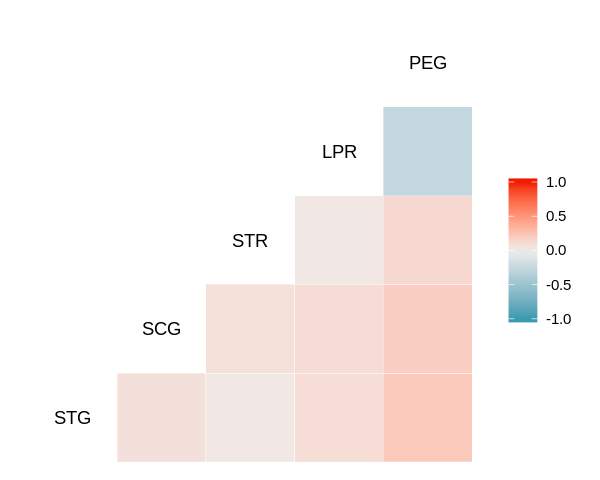

In [44]:
options(repr.plot.height = 4)
library(GGally)

ggcorr(training_data, method = c("everything", "pearson"))

Plotting the correlation matrix between the predictor variables shows low correlations between each of the 5 predictors, so multicollinearity issues are unlikely to be a consideration in feature selection. Thus, any combination of these variables is plausible.

Then, the function ggpairs is used to compare the distributions and values of each predictor.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



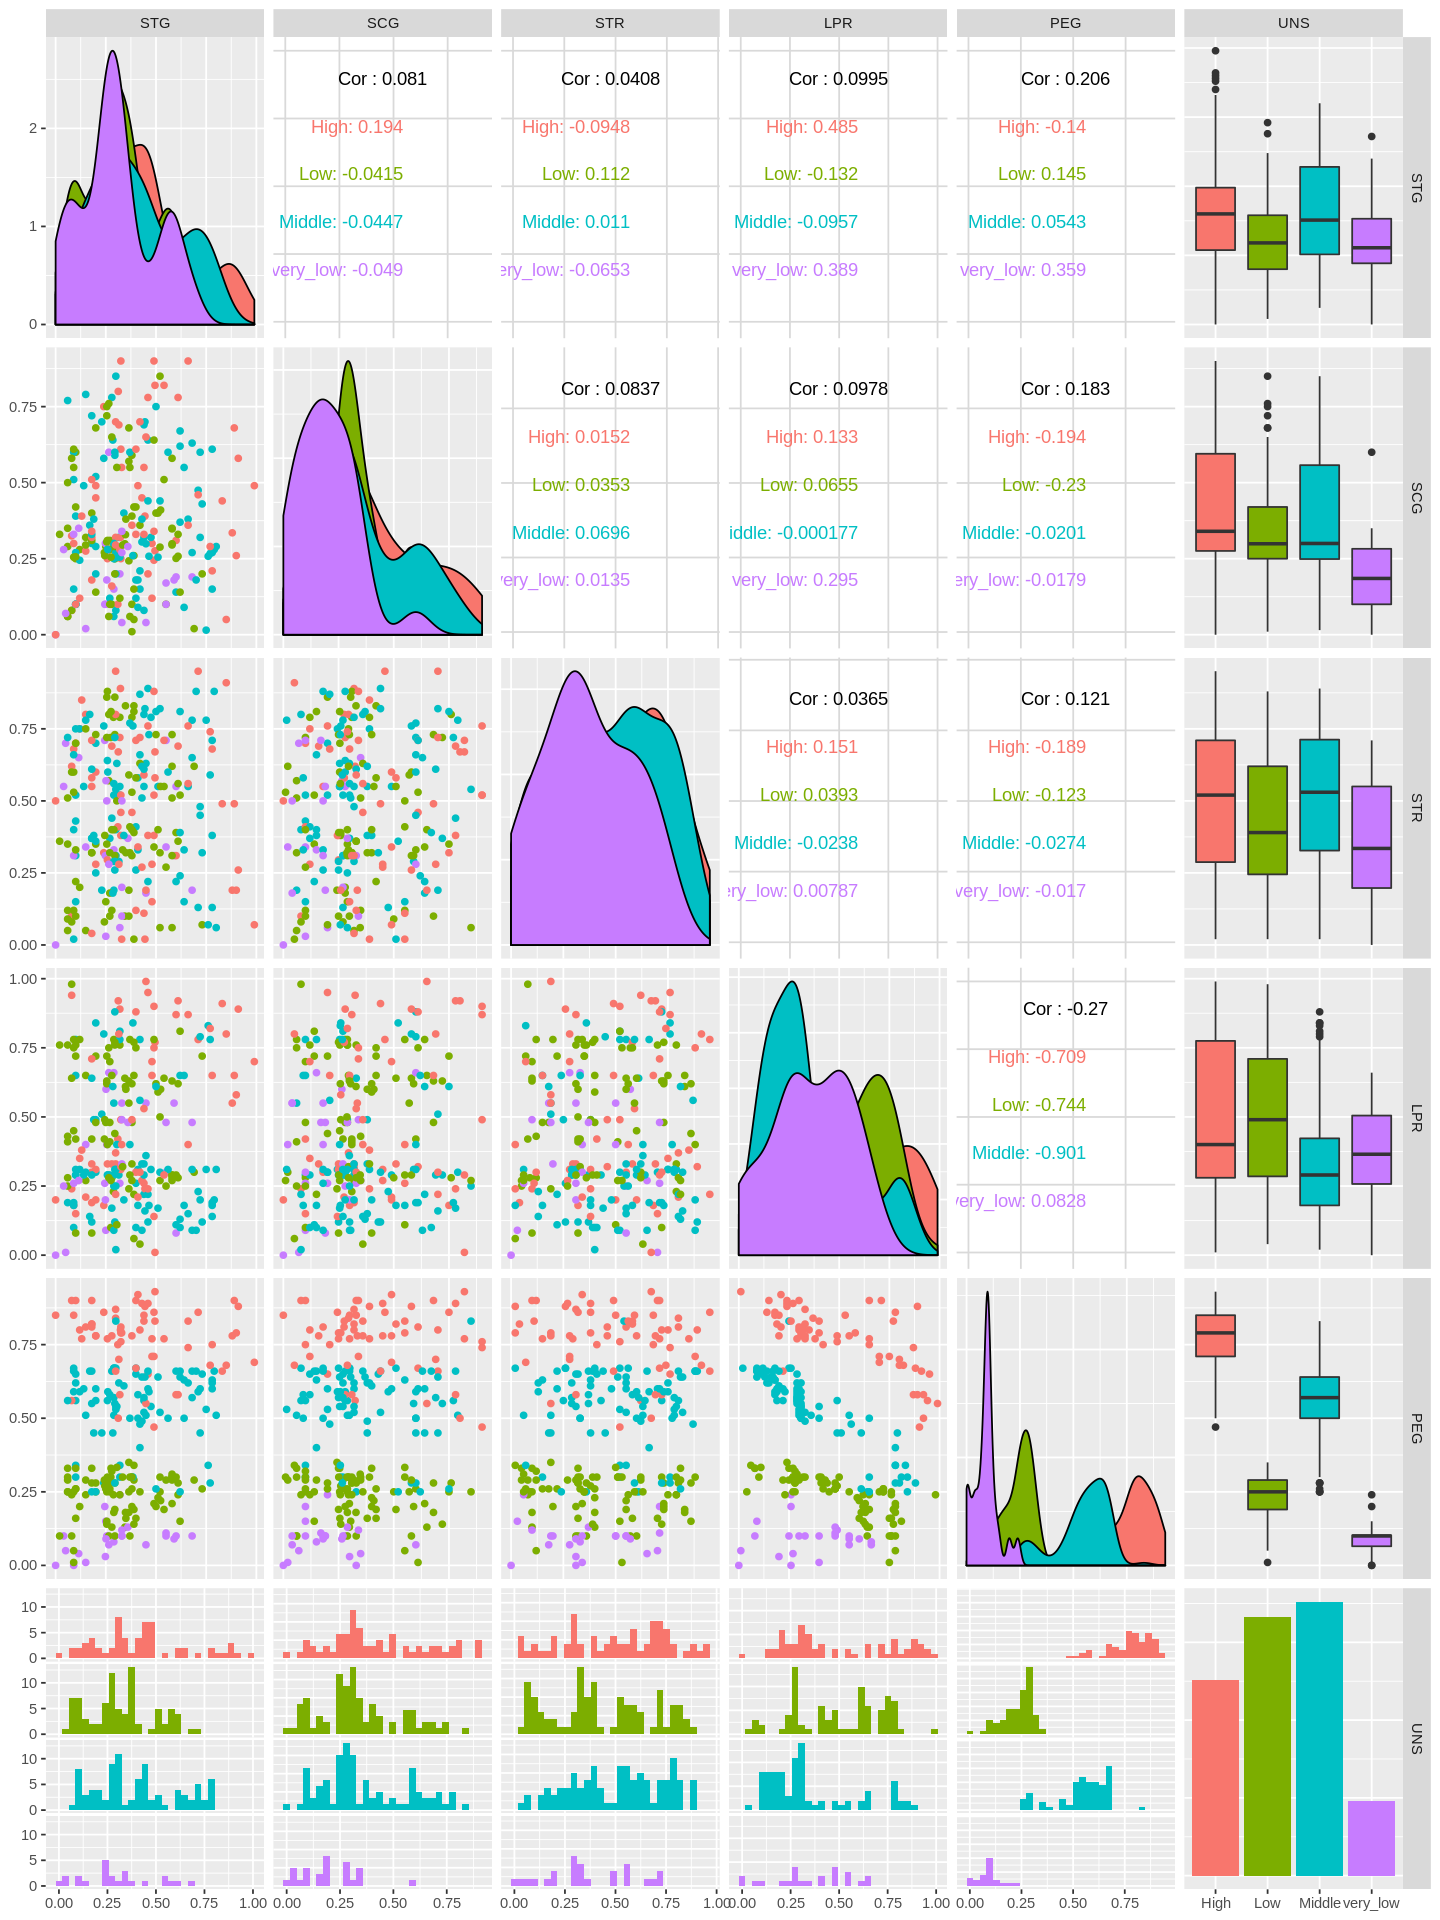

In [45]:
options(repr.plot.height = 16, repr.plot.width = 12)
ggpairs(training_data, columns = 1:6, ggplot2::aes(colour=UNS))

The ggpairs visualization  establishes that the distributions of each UNS category are most differentiated in relation to PEG, relative to the other variables. The filled area plots of PEG for each UNS category reveals that the “High” class takes standardized PEG values between 0.4 and 1 while users in the "Very Low" class appear to only possess PEG scores between the standardized values of 0.00 to 0.25 in the filled area plot. 

Since the distributions of PEG values vary greatly across the UNS levels, PEG will be a good predictor of UNS levels and should therefore be included in the model. 

Aside PEG, we are also chooing two other variables, STG (studying done) and LPR (exam performance on related topics), that also show noticeable variation in distribution for different levels of UNS (albeit to a lesser degree) in comparison to SCG (practice done) and STR (prerequisite knowledge). Therefore, STR and LPR will have a greater impact on UNS than SCG (practice time) and STR (practice done). In addition, SCG is very similar to STG as both revolve around studying while STR is very similar to LPR as both measure the user's knowledge on assisting information (Karaman et al. 285). Due to the similarities of the variables and the variance in quality as possible predictors, STG and LPR will be used as predictors while SCG and STR will not.

## Classification

We head the training data and testing data to check if any data wrangling or cleaning is needed.

In [46]:
head(training_data)
head(testing_data)

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.10,0.50,0.26,0.05,Very Low
0.05,0.05,0.55,0.60,0.14,Low
0.08,0.18,0.63,0.60,0.85,High
0.20,0.20,0.68,0.67,0.85,High
0.22,0.22,0.90,0.30,0.90,High
0.14,0.14,0.70,0.50,0.30,Low


The testing and training data have different labels in the UNS column; the training data said uses the label "very_low" while the testing data uses the label "Very Low". Thus, the training data will be cleaned so that it too uses the label "Very Low". No other data modification is needed as the data set is quite clean.

In [47]:
# use new dataframe - do not change old 
training_data_clean <- training_data

# chanmge UNS to character
training_data_clean$UNS = as.character(training_data_clean$UNS)

# change very_low to Very Low
training_data_clean[training_data_clean$UNS == "very_low", "UNS"] <- "Very Low"

# change UNS back to factor 
training_data_clean$UNS = as.factor(training_data_clean$UNS)

# training_data
head(training_data_clean)


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,0.00,0.00,Very Low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle


The labels in the training and testing data now match each other! Now that the data set is completely clean, we can start with the knn classification. As discussed in the previous section, we will create the data frame X_train with the three predictor variables we are using: PEG, STR, and LPR. Then, we will create a vector Y_train which contains all values of UNS. 

In [48]:
# run knn with PEG, STG and LPR 

# get training data 
X_train <- training_data_clean %>%
select(PEG, STG, LPR) %>%
data.frame()

Y_train <- training_data_clean %>%
select(UNS) %>%
unlist()

glimpse(X_train)

head(Y_train)

Observations: 258
Variables: 3
$ PEG <dbl> 0.00, 0.90, 0.33, 0.30, 0.24, 0.66, 0.56, 0.01, 0.25, 0.85, 0.81,…
$ STG <dbl> 0.00, 0.08, 0.06, 0.10, 0.08, 0.09, 0.10, 0.15, 0.20, 0.00, 0.18,…
$ LPR <dbl> 0.00, 0.24, 0.25, 0.65, 0.98, 0.10, 0.29, 0.40, 0.72, 0.20, 0.30,…


UNS1     UNS2     UNS3     UNS4     UNS5     UNS6 
Very Low     High      Low   Middle      Low   Middle 
Levels: High Low Middle Very Low

We repeat this same process with the testing data.

In [49]:
# get testing data 
X_test<- testing_data %>%
select(PEG, STG, LPR) %>%
data.frame()

Y_test <- testing_data %>%
select(UNS) %>%
unlist()

glimpse(X_test)

head(Y_test)

Observations: 145
Variables: 3
$ PEG <dbl> 0.05, 0.14, 0.85, 0.85, 0.90, 0.30, 0.50, 0.15, 0.80, 0.07, 0.66,…
$ STG <dbl> 0.00, 0.05, 0.08, 0.20, 0.22, 0.14, 0.16, 0.12, 0.20, 0.16, 0.11,…
$ LPR <dbl> 0.26, 0.60, 0.60, 0.67, 0.30, 0.50, 0.50, 0.68, 0.77, 0.10, 0.05,…


UNS1     UNS2     UNS3     UNS4     UNS5     UNS6 
Very Low      Low     High     High     High      Low 
Levels: High Low Middle Very Low

Now, we will find the optimal value of k. First, a data frame containing possible values of k is created. It contains the all integers from 1 to 30. 

In [50]:
# try k from 1 to 30, by increments of 1 

k_ls <- data.frame(k = seq(from = 1, to = 30, by = 1))

head(k_ls)

,k
,<dbl>
1,1
2,2
3,3
4,4
5,5
6,6


To test for the optimal k value, we will use 5-fold cross validation. By using cross validation to determine our k value, we ensure that it is as accurate as possible (Add more). Using the possible k values and cross validation, we will train our model. 

In [51]:
# use 5 - fold cross validation 

train_control <- trainControl(method="cv", number = 5)
# train model 
user_knn_model <- train(x = X_train, 
                        y = Y_train, 
                        method = "knn", 
                        tuneGrid = k_ls, 
                        trControl = train_control)

user_knn_model

k-Nearest Neighbors 

258 samples
  3 predictor
  4 classes: 'High', 'Low', 'Middle', 'Very Low' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 206, 206, 206, 206, 208 
Resampling results across tuning parameters:

  k   Accuracy   Kappa    
   1  0.9220000  0.8902558
   2  0.9106154  0.8740118
   3  0.9261538  0.8961187
   4  0.9261538  0.8962540
   5  0.9147692  0.8794839
   6  0.8916923  0.8461682
   7  0.9032308  0.8618287
   8  0.8876923  0.8393572
   9  0.8838462  0.8337968
  10  0.8723077  0.8170734
  11  0.8684615  0.8115917
  12  0.8646154  0.8057968
  13  0.8607692  0.8004068
  14  0.8452308  0.7777031
  15  0.8606154  0.8001253
  16  0.8529231  0.7888975
  17  0.8413846  0.7716369
  18  0.8375385  0.7659839
  19  0.8375385  0.7663666
  20  0.8335385  0.7600193
  21  0.8296923  0.7541628
  22  0.8256923  0.7482114
  23  0.8256923  0.7484123
  24  0.8180000  0.7366472
  25  0.8180000  0.7365131
  26  0.8103077  0.7249966
  27  0.8103077  0.7

A table is used to show the results of training the model:

In [52]:
testing_accuracies <- user_knn_model$results

head(testing_accuracies)

,k,Accuracy,Kappa,AccuracySD,KappaSD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0.9220000,0.8902558,0.04050203,0.05663477
2,2,0.9106154,0.8740118,0.02705681,0.03748205
3,3,0.9261538,0.8961187,0.02600068,0.03605864
4,4,0.9261538,0.8962540,0.03508232,0.04865992
5,5,0.9147692,0.8794839,0.02169858,0.02998166
6,6,0.8916923,0.8461682,0.03930385,0.05664246


To visualize our results, we create a graph where the value of k is on the x axis and the accuracy of model is on the y axis. 

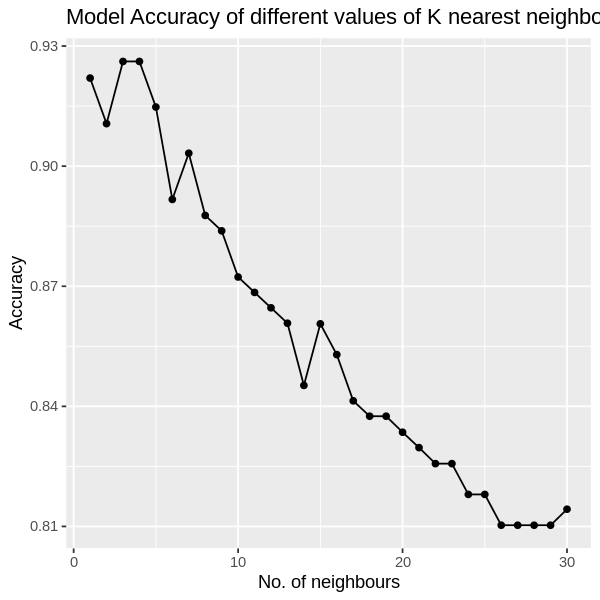

In [53]:
# k = 3 is best model 

# plot accuracy on testing data 

testing_accuracy_plot <- testing_accuracies %>%
ggplot(aes(x = k, y = Accuracy)) + 
geom_point() + 
geom_line() + 
labs(x = "No. of neighbours", y = "Accuracy") + 
ggtitle("Model Accuracy of different values of K nearest neighbours")
#Model Accuracy on testing data for different K values
options(repr.plot.width = 5, repr.plot.height = 5)

testing_accuracy_plot

Based off of the diagram, it is clear that k = 3 provides our model the highest accuracy and will be our chosen k value. Now using this value, we will now train our model using the training data. 

In [54]:
# k = 3 gives highest accuracy 

# use k = 3 for final model 
k_best <- data.frame(k = 3)

#train using k = 3 
model_k_3 <- train(x = X_train, y = Y_train, method = "knn", tuneGrid = k_best, trControl = train_control)

model_k_3

k-Nearest Neighbors 

258 samples
  3 predictor
  4 classes: 'High', 'Low', 'Middle', 'Very Low' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 207, 207, 207, 206, 205 
Resampling results:

  Accuracy   Kappa    
  0.9146945  0.8792591

Tuning parameter 'k' was held constant at a value of 3

The accuracy of the model on training test was found to be approximately 93%.

Using the model, we will now use it to predict the labels of our testing data as well as determine its accuracy in this action.

In [55]:
# get accuracy on testing data 

# predict labels on testing set 
test_predictions <- predict(object = model_k_3, X_test)
# test_predictions 

# Y_test

# compute the accuracy 
model_quality <- confusionMatrix(data = test_predictions, reference = Y_test)
model_quality 

Confusion Matrix and Statistics

          Reference
Prediction High Low Middle Very Low
  High       39   0      1        0
  Low         0  45      3        3
  Middle      0   1     30        0
  Very Low    0   0      0       23

Overall Statistics
                                          
               Accuracy : 0.9448          
                 95% CI : (0.8942, 0.9759)
    No Information Rate : 0.3172          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.925           
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: High Class: Low Class: Middle Class: Very Low
Sensitivity               1.0000     0.9783        0.8824          0.8846
Specificity               0.9906     0.9394        0.9910          1.0000
Pos Pred Value            0.9750     0.8824        0.9677          1.0000
Neg Pred Value            1.0000     0.98

Using our model to predict the labels of the testing data, it was found to be over 94% accurate! To determine the areas in which the model predicted in accurately, we will create 3 pairs of scatter plots in which the 3 different pair combinations of the 3 predictors are plotted using two scatter plots side by side; one with the true labels and one with the predicted labels. The observations that were predicted incorrectly will be circled. 

In [56]:
# plot against actual labels -> UNS on x axis, each factor on y axis, coloured by prediction
all_predictions <- data.frame(Y_test, data.frame(test_predictions), X_test) 
head(all_predictions)

,Y_test,test_predictions,PEG,STG,LPR
,<fct>,<fct>,<dbl>,<dbl>,<dbl>
UNS1,Very Low,Very Low,0.05,0.00,0.26
UNS2,Low,Low,0.14,0.05,0.60
UNS3,High,High,0.85,0.08,0.60
UNS4,High,High,0.85,0.20,0.67
UNS5,High,High,0.90,0.22,0.30
UNS6,Low,Low,0.30,0.14,0.50


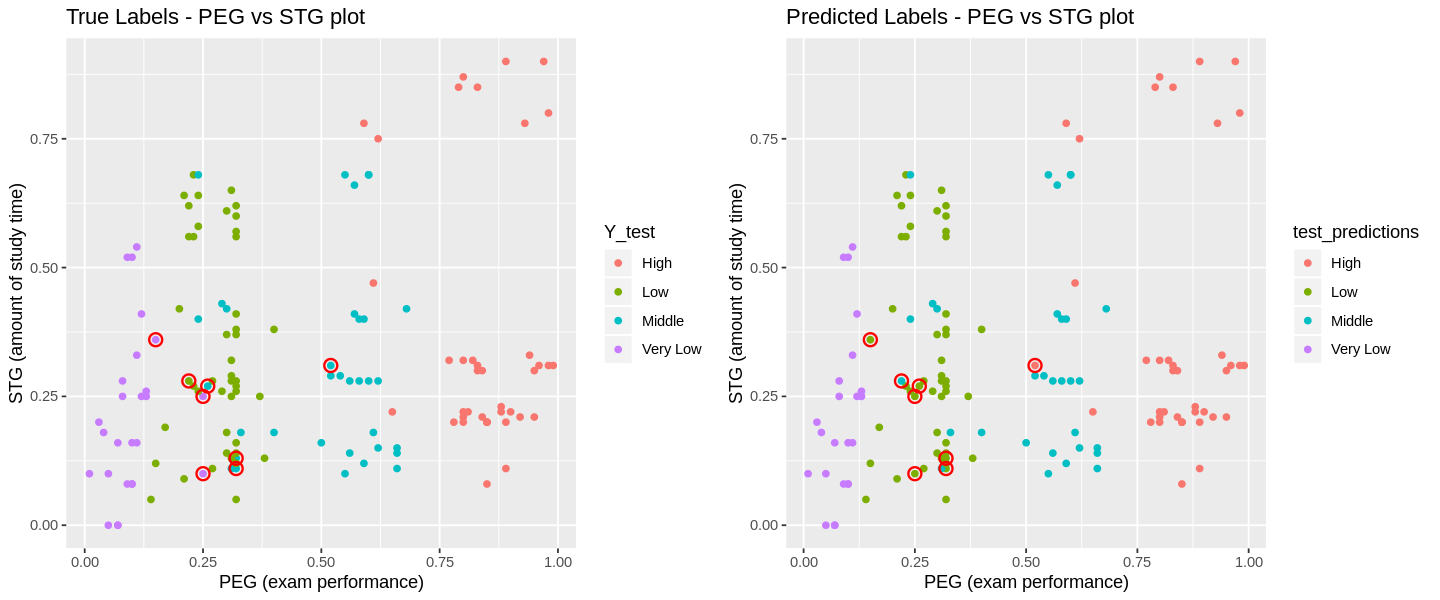

In [57]:
library(gridExtra)
options(repr.plot.height = 5, repr.plot.width = 12)
prediction_plot_true <- ggplot(all_predictions, aes(x = PEG, y = STG, color = Y_test)) +
        geom_point() +
        labs(x = "PEG (exam performance)", y = "STG (amount of study time)", title = "True Labels - PEG vs STG plot") +
        geom_point(data=all_predictions[all_predictions$Y_test!=all_predictions$test_predictions, ],
             pch=21, fill=NA, size=3, colour="red", stroke=1)

prediction_plot_false <-  ggplot(all_predictions, aes(x = PEG, y = STG, color = test_predictions)) +
        geom_point() +
        labs(x = "PEG (exam performance)", y = "STG (amount of study time)", title = "Predicted Labels - PEG vs STG plot") +
        geom_point(data=all_predictions[all_predictions$Y_test!=all_predictions$test_predictions, ],
             pch=21, fill=NA, size=3, colour="red", stroke=1)

grid.arrange(prediction_plot_true, prediction_plot_false, ncol=2)



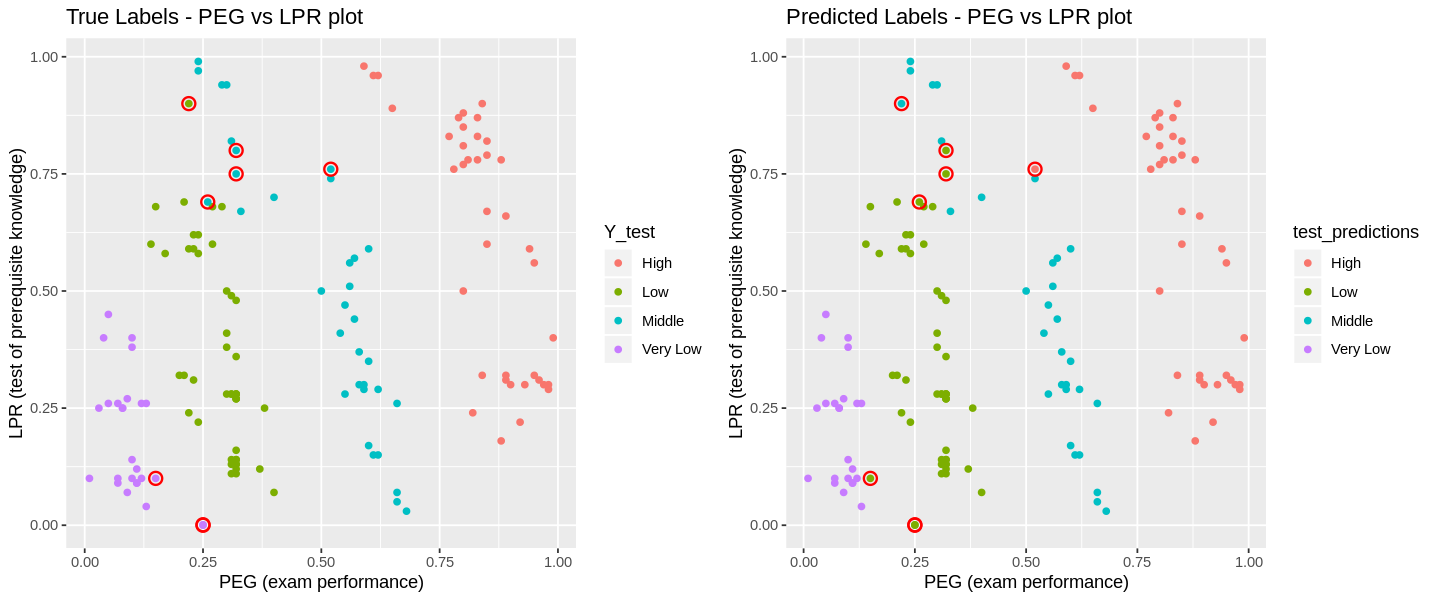

In [58]:
library(gridExtra)
options(repr.plot.height = 5, repr.plot.width = 12)
prediction_plot_true <- ggplot(all_predictions, aes(x = PEG, y = LPR, color = Y_test)) +
        geom_point() +
    labs(x = "PEG (exam performance)", y = "LPR (test of prerequisite knowledge)", title = "True Labels - PEG vs LPR plot") +
        geom_point(data=all_predictions[all_predictions$Y_test!=all_predictions$test_predictions, ],
             pch=21, fill=NA, size=3, colour="red", stroke=1)

prediction_plot_false <-  ggplot(all_predictions, aes(x = PEG, y = LPR, color = test_predictions)) +
        geom_point() +
        labs(x = "PEG (exam performance)", y = "LPR (test of prerequisite knowledge)", title = "Predicted Labels - PEG vs LPR plot") +
        geom_point(data=all_predictions[all_predictions$Y_test!=all_predictions$test_predictions, ],
             pch=21, fill=NA, size=3, colour="red", stroke=1)

grid.arrange(prediction_plot_true, prediction_plot_false, ncol=2)



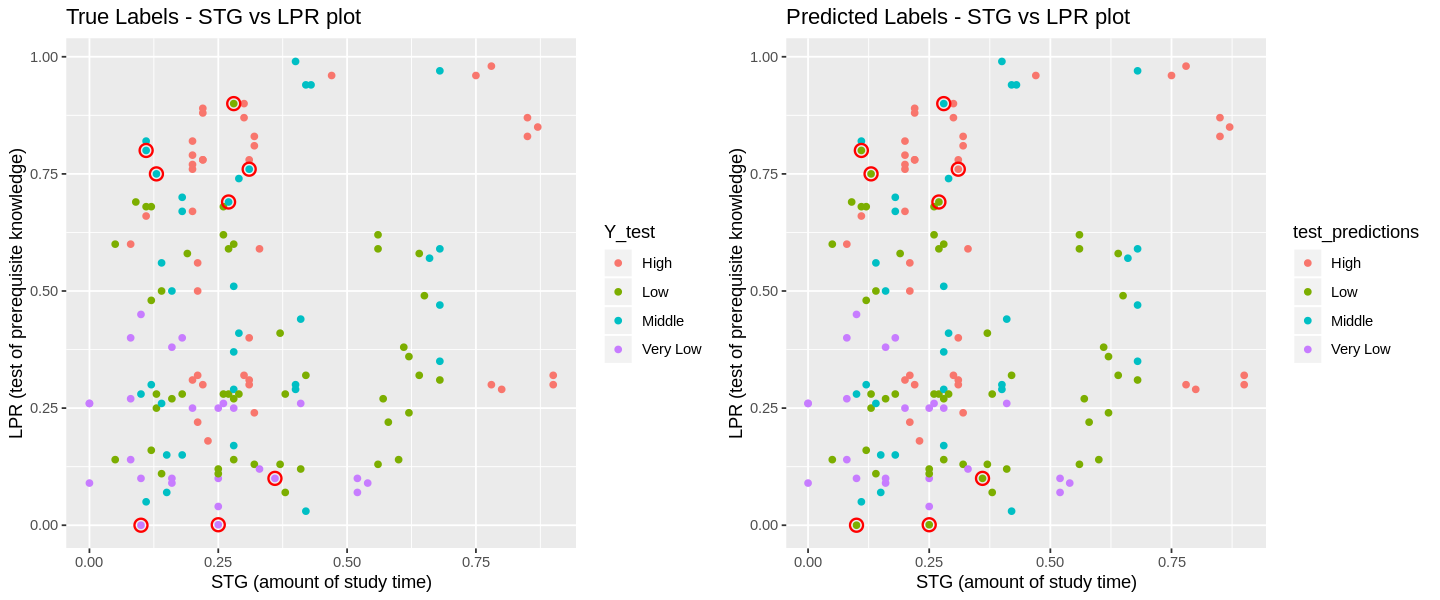

In [59]:
library(gridExtra)
options(repr.plot.height = 5, repr.plot.width = 12)
prediction_plot_true <- ggplot(all_predictions, aes(x = STG, y = LPR, color = Y_test)) +
        geom_point() +
    labs(x = "STG (amount of study time)", y = "LPR (test of prerequisite knowledge)", title = "True Labels - STG vs LPR plot") +
        geom_point(data=all_predictions[all_predictions$Y_test!=all_predictions$test_predictions, ],
             pch=21, fill=NA, size=3, colour="red", stroke=1)

prediction_plot_false <-  ggplot(all_predictions, aes(x = STG, y = LPR, color = test_predictions)) +
        geom_point() +
        labs(x = "STG (amount of study time)", y = "LPR (test of prerequisite knowledge)", title = "Predicted Labels - STG vs LPR plot") +
        geom_point(data=all_predictions[all_predictions$Y_test!=all_predictions$test_predictions, ],
             pch=21, fill=NA, size=3, colour="red", stroke=1)

grid.arrange(prediction_plot_true, prediction_plot_false, ncol=2)



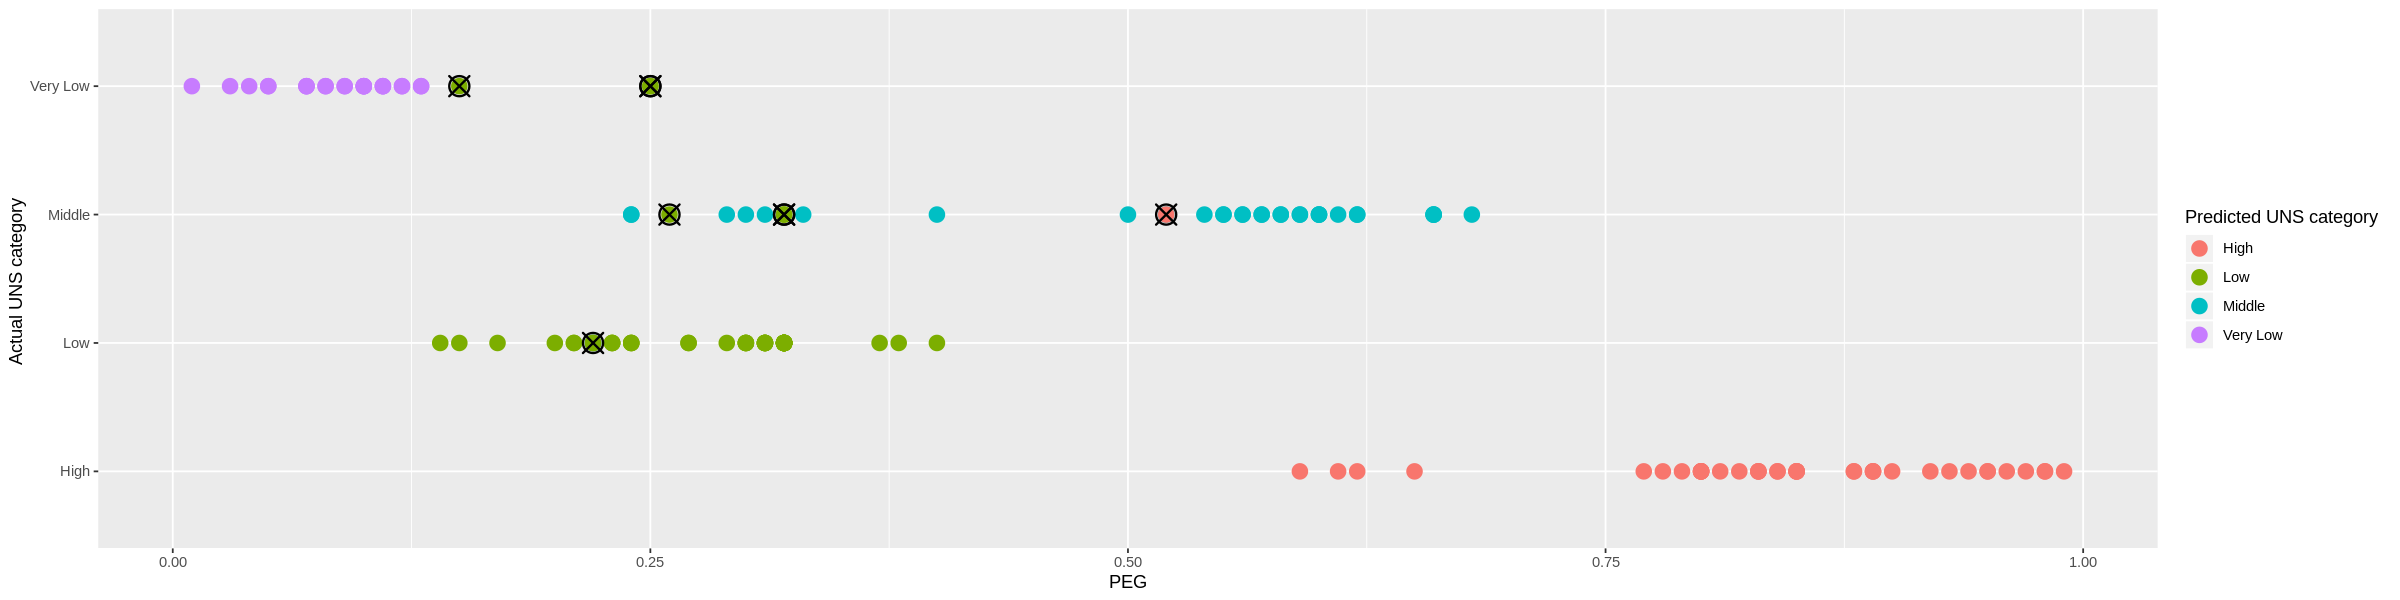

In [69]:
options(repr.plot.height = 5, repr.plot.width = 20)
predictions_plot_peg <- all_predictions %>%
ggplot(aes(x = Y_test, y = PEG, colour = test_predictions)) +
geom_point(size = 4) + 
labs(x = "Actual UNS category ", y = "PEG", colour = "Predicted UNS category") + 
coord_flip() +
geom_point(data=all_predictions[all_predictions$Y_test!=all_predictions$test_predictions, ],
             pch=13, fill=NA, size=5, colour="black", stroke=1)


predictions_plot_peg

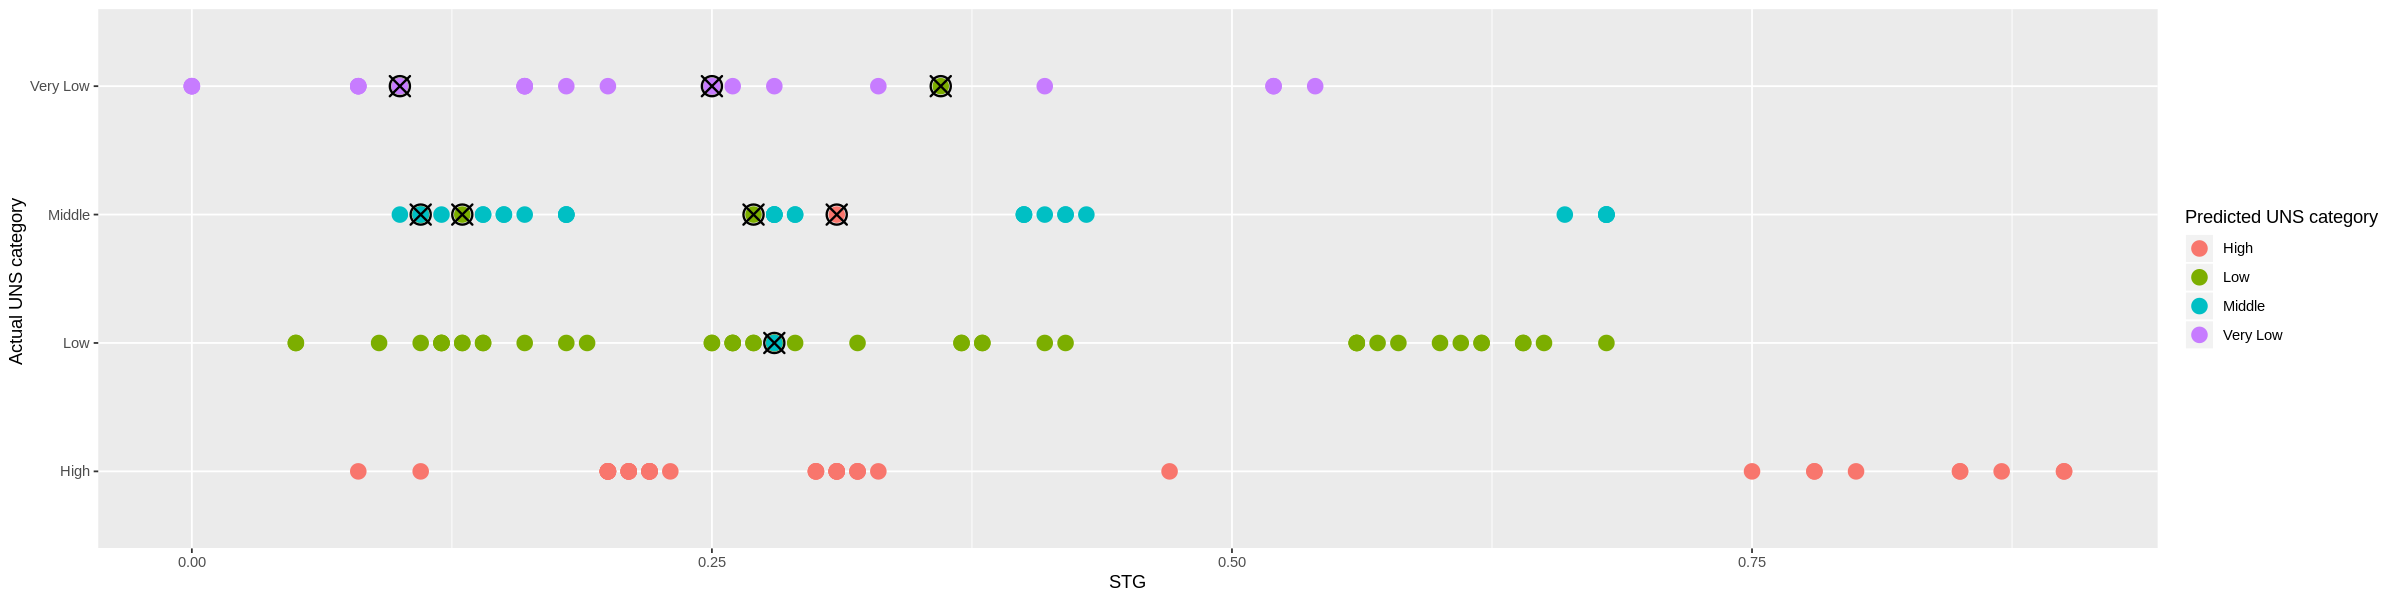

In [70]:
options(repr.plot.height = 5, repr.plot.width = 20)
predictions_plot_stg <- all_predictions %>%
ggplot(aes(x = Y_test, y = STG, colour = test_predictions)) +
geom_point(size = 4) + 
labs(x = "Actual UNS category ", y = "STG", colour = "Predicted UNS category")+ 
coord_flip()+
geom_point(data=all_predictions[all_predictions$Y_test!=all_predictions$test_predictions, ],
             pch=13, fill=NA, size=5, colour="black", stroke=1)


predictions_plot_stg

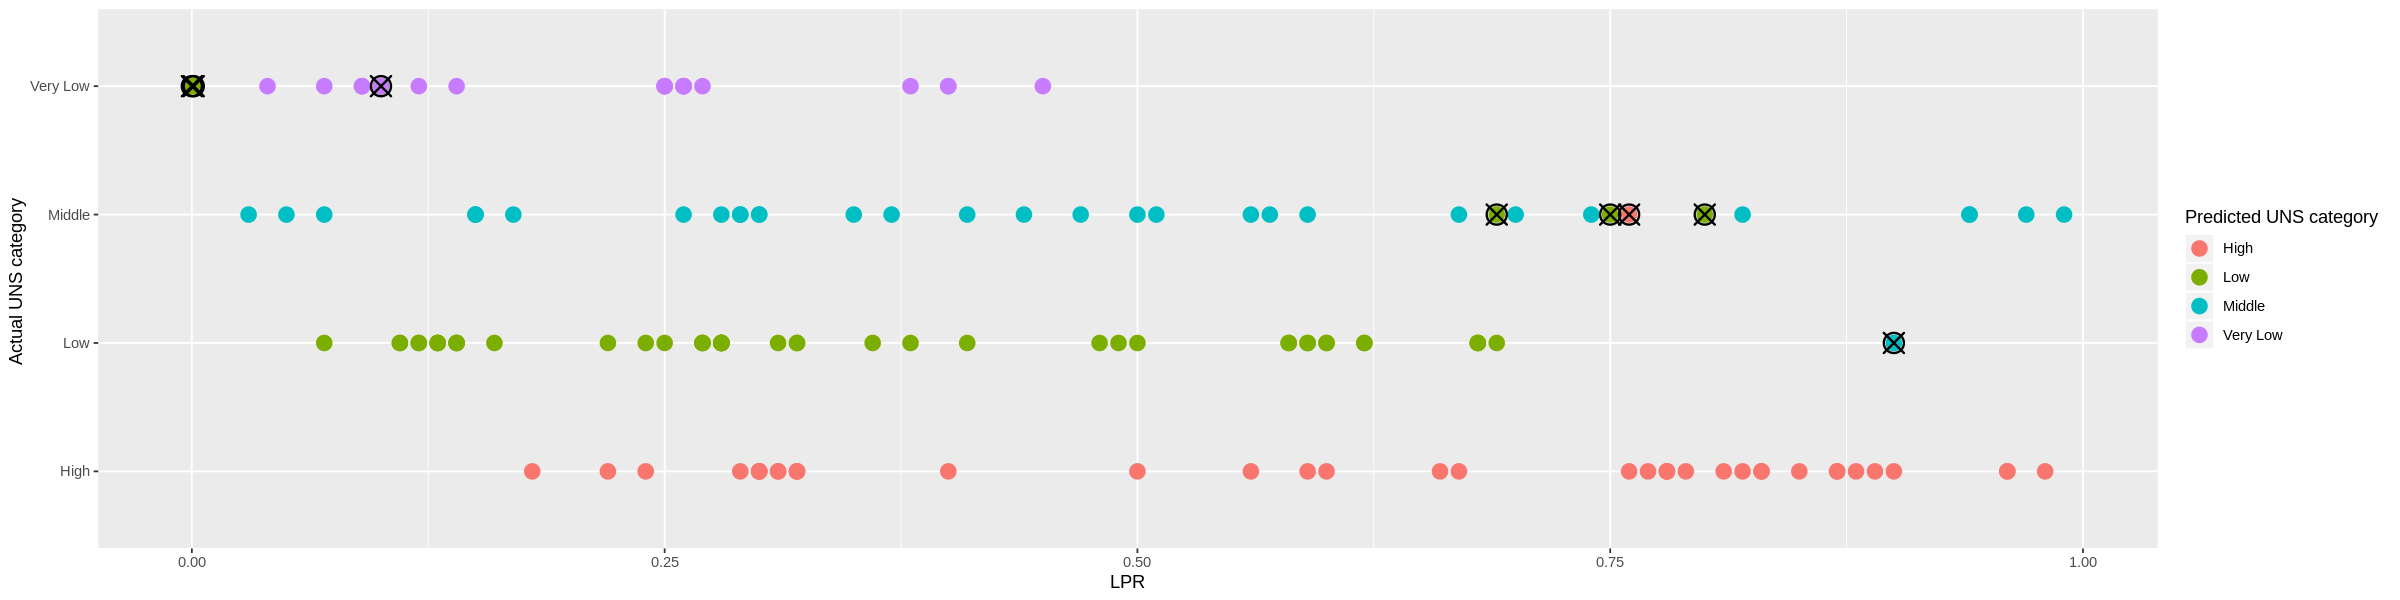

In [71]:
options(repr.plot.height = 5, repr.plot.width = 20)
predictions_plot_lpr <- all_predictions %>%
ggplot(aes(x = Y_test, y = LPR, colour = test_predictions)) +
geom_point(size = 4) + 
labs(x = "Actual UNS category ", y = "LPR", colour = "Predicted UNS category")+ 
coord_flip() +
geom_point(data=all_predictions[all_predictions$Y_test!=all_predictions$test_predictions, ],
             pch=13, fill=NA, size=5, colour="black", stroke=1)


predictions_plot_lpr

In [63]:
## discussion

## Methods

Little data wrangling is required for our project on the User Knowledge dataset as it is in a format that can already be used for k-nn classification. We will be using three predictors (STG, LPR and PEG) and their values in our KNN model. These predictors were chosen due to the more distinctive difference in their mean values which assures that the data for different UNS classes are not clustering around the same range. To analyse our dataset, we will use scatterplot graphs to convey the overall picture. A data frame with four columns will be used: STG, LPR, PEG, and the knowledge level of users. Three pairs of scatter plot graphs will be made to compare the classification of values made by our model versus the true classes of the values. Each scatter plot pair will plot a unique pair of the three predictors that are being used while the classes of the values will be used to color the points, one scatter plot having the predicted classes while the other the true classes. The resulting scatter plot will have predictors on both axes and points colored by the predicted labels and also the true labels (UNS). 
